In [ ]:
!pip install -q pandas apyori matplotlib seaborn streamlit squarify efficient_apriori mlxtend

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import time
import re
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from itertools import combinations
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
from mlxtend.preprocessing import TransactionEncoder
import networkx as nx
import squarify
import datetime
import streamlit as st

## 0. Initialise Dataframe

In [ ]:
# Loading data from CSV files into pandas DataFrames
catalogo_df = pd.read_csv('Catalogo.csv')          # Loading Catalogo data
compra_df = pd.read_csv('Compra.csv')              # Loading Compra data
compraitem_df = pd.read_csv('CompraItem.csv')      # Loading CompraItem data
produto_df = pd.read_csv('Produto.csv')            # Loading Produto data
fornecedor_df = pd.read_csv('Fornecedor.csv')      # Loading Fornecedor data
groupproduto_df = pd.read_csv('GrupoProduto.csv')  # Loading GrupoProduto data
ursuario_df = pd.read_csv('Usuario.csv')           # Loading Usuario data
venda_df = pd.read_csv('Venda.csv')                # Loading Venda data
vendaitem_df = pd.read_csv('VendaItem.csv')        # Loading VendaItem data

## 1. Clean Dataset

In [ ]:
# List of all dataframes
dataframes = [
    catalogo_df, compra_df, compraitem_df, produto_df, fornecedor_df,
    groupproduto_df, ursuario_df, venda_df, vendaitem_df
]

# Names of dataframes for cleaning
dataframe_names = [
    "Catalogo", "Compra", "CompraItem", "Produto", "Fornecedor",
    "GrupoProduto", "Usuario", "Venda", "VendaItem"
]

# Function to remove empty columns from a dataframe
def remove_empty_columns(df):
    # Drop columns with all values of NaN
    return df.dropna(axis=1, how='all')

for df, name in zip(dataframes, dataframe_names):
    original_columns = df.shape[1]
    df_cleaned = remove_empty_columns(df)
    cleaned_columns = df_cleaned.shape[1]
    globals()[f"{name.lower()}_df"] = df_cleaned
    print(f"Removed {original_columns - cleaned_columns} empty columns from {name}")
    print(f"Original shape: {df.shape}, New shape: {df_cleaned.shape}")
    print()

print("All dataframes cleaned.")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Removed 3 empty columns from Catalogo
Original shape: (18263, 30), New shape: (18263, 27)

Removed 8 empty columns from Compra
Original shape: (216420, 22), New shape: (216420, 14)

Removed 3 empty columns from CompraItem
Original shape: (1077059, 27), New shape: (1077059, 24)

Removed 4 empty columns from Produto
Original shape: (118386, 100), New shape: (118386, 96)

Removed 0 empty columns from Fornecedor
Original shape: (14311, 20), New shape: (14311, 20)

Removed 4 empty columns from GrupoProduto
Original shape: (4055, 20), New shape: (4055, 16)

Removed 5 empty columns from Usuario
Original shape: (4268, 13), New shape: (4268, 8)

Removed 5 empty columns from Venda
Original shape: (1000000, 68), New shape: (1000000, 63)

Removed 12 empty columns from Venda_random
Original shape: (15000, 68), New shape: (15000, 56)

Removed 6 empty columns from VendaItem
Original shape: (1000000, 38), New shape: (1000000, 32)

Removed 5 empty columns from VendaItem_random
Original shape: (15000, 3

## 2. Exploratory Data Analysis on Sales Data

In [ ]:
venda_df = venda_df.head(75000)
vendaitem_df = vendaitem_df.head(75000)

# Merge the dataframes
sales_data = pd.merge(venda_df, vendaitem_df, on=['Emp', 'Vd'])
sales_data = pd.merge(sales_data, produto_df, on='Prd')

# Convert date to datetime
sales_data['Vd_DtGerencial'] = pd.to_datetime(sales_data['Vd_DtGerencial'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 2.1. Time Series of Daily Sales

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


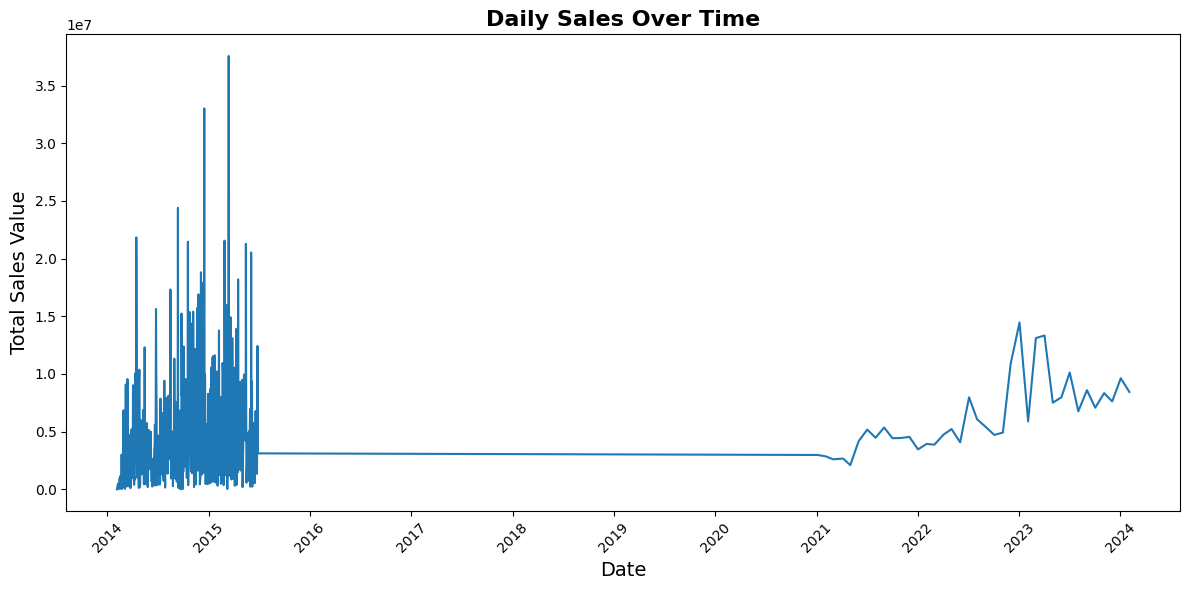

In [ ]:
# Creating a time series of daily sales by grouping the data by date and summing the sales values
daily_sales = sales_data.groupby('Vd_DtGerencial')['Vd_VrProdutos'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='Vd_DtGerencial', y='Vd_VrProdutos', data=daily_sales)
plt.title('Daily Sales Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Sales Value', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 2.2. Most Frequent Product Count

In [ ]:
# Identifying the most frequently sold products by counting occurrences
most_frequent_products = sales_data['Prd_Desc'].value_counts()

# Converting the result to a DataFrame
most_frequent_products_df = most_frequent_products.reset_index()
most_frequent_products_df.columns = ['Product', 'Count']

# Printing the result
print(most_frequent_products_df)

                                             Product   Count
0                                           Generico  197255
1                                Ice Tea Limão 300ml  105709
2                                                  X   41892
3                                    Pão Gergelim Un   24339
4                           CAIXA MADEIRA QUADRADO M   24339
...                                              ...     ...
30013  Tapioca queijo minas tomate seco e manjericão       1
30014                       Colorado Long Neck 300ml       1
30015                                  Pudim de Chia       1
30016                         Filet Mignon ao Funghi       1
30017                                PAO DE RABANADA       1

[30018 rows x 2 columns]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Set a threshold for high-frequency products
threshold = 20000

# Filter out high-frequency products
filtered_products_df = most_frequent_products_df[most_frequent_products_df['Count'] <= threshold]

print(filtered_products_df)

filtered_sales_data = sales_data[sales_data['Prd_Desc'].isin(filtered_products_df['Product'])]

print(filtered_sales_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                                             Product  Count
6                                          Coca Cola  19370
7                        Matte Leão Natural Wf 300ml  17306
8              Cerveja Stella Artois Long Neck 330ml  17095
9                                              Pudim  16855
10               Uramaki Pate De Salmao (5 Unidades)  16226
...                                              ...    ...
30013  Tapioca queijo minas tomate seco e manjericão      1
30014                       Colorado Long Neck 300ml      1
30015                                  Pudim de Chia      1
30016                         Filet Mignon ao Funghi      1
30017                                PAO DE RABANADA      1

[30012 rows x 2 columns]
          Emp_x     Vd    Trn    Mes  Cli     Vd_MesaDesc Vd_DtGerencial  \
0             1      1    1.0    NaN  NaN  1099 Comedoria     2021-01-04   
1             1      1    1.0    NaN  NaN  1099 Comedoria     2021-01-04   
2             1      1    

## 2.3. Top Most Frequent Products (Filtered)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


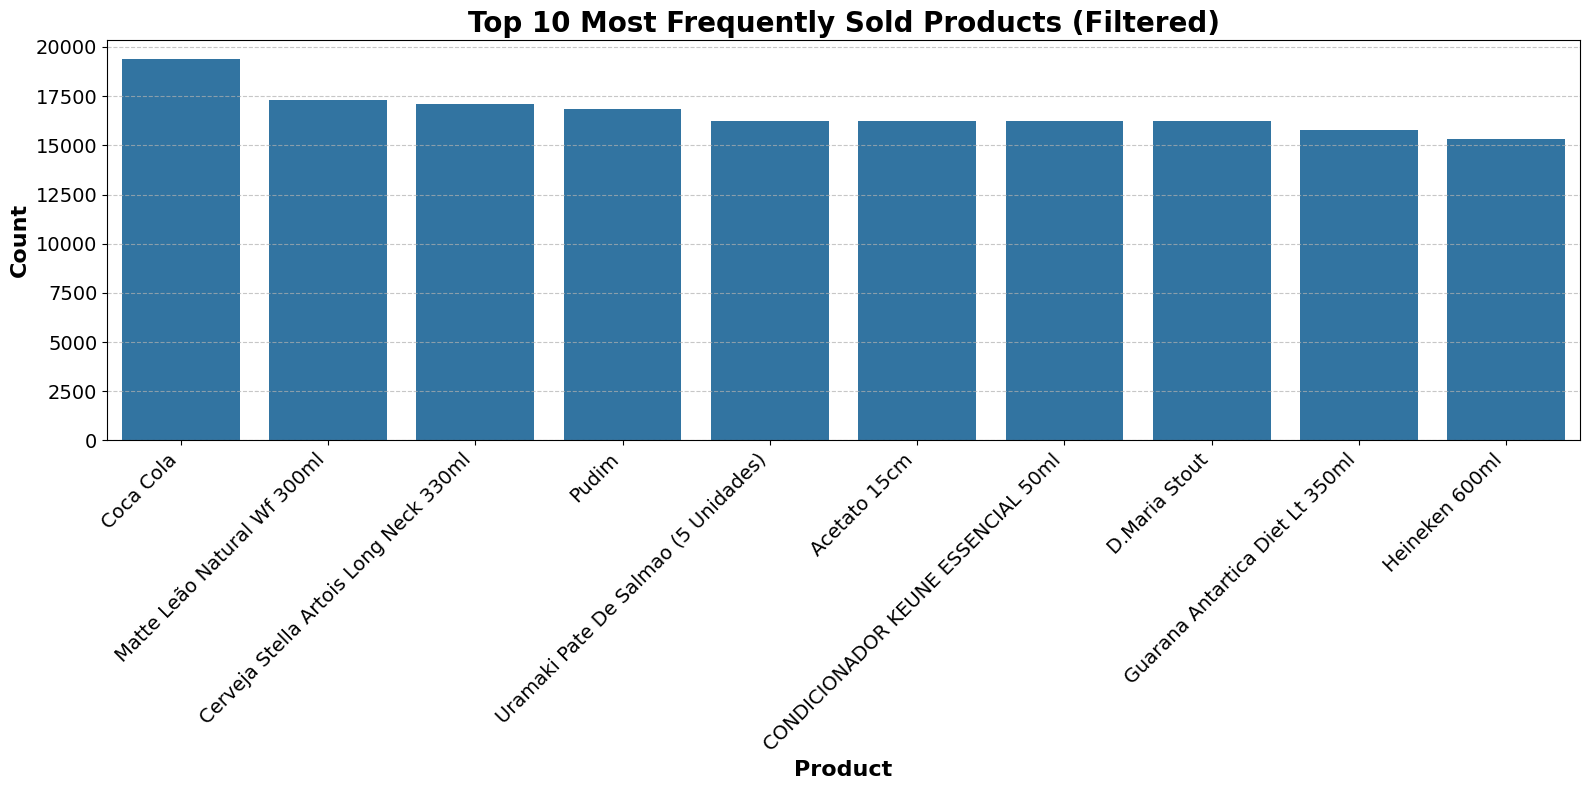

In [ ]:
top_frequent_products_df = filtered_products_df.head(10)

plt.figure(figsize=(16, 8))

sns.barplot(x='Product', y='Count', data=top_frequent_products_df)

plt.title('Top 10 Most Frequently Sold Products (Filtered)', fontsize=20, fontweight='bold')
plt.xlabel('Product', fontsize=16, fontweight='bold')
plt.ylabel('Count', fontsize=16, fontweight='bold')

plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 2.5. Top 10 Selling Products by Sale Value

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-11-c74a3d494888>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Product', y='Total Sales Value', data=top_products_df, palette='viridis')


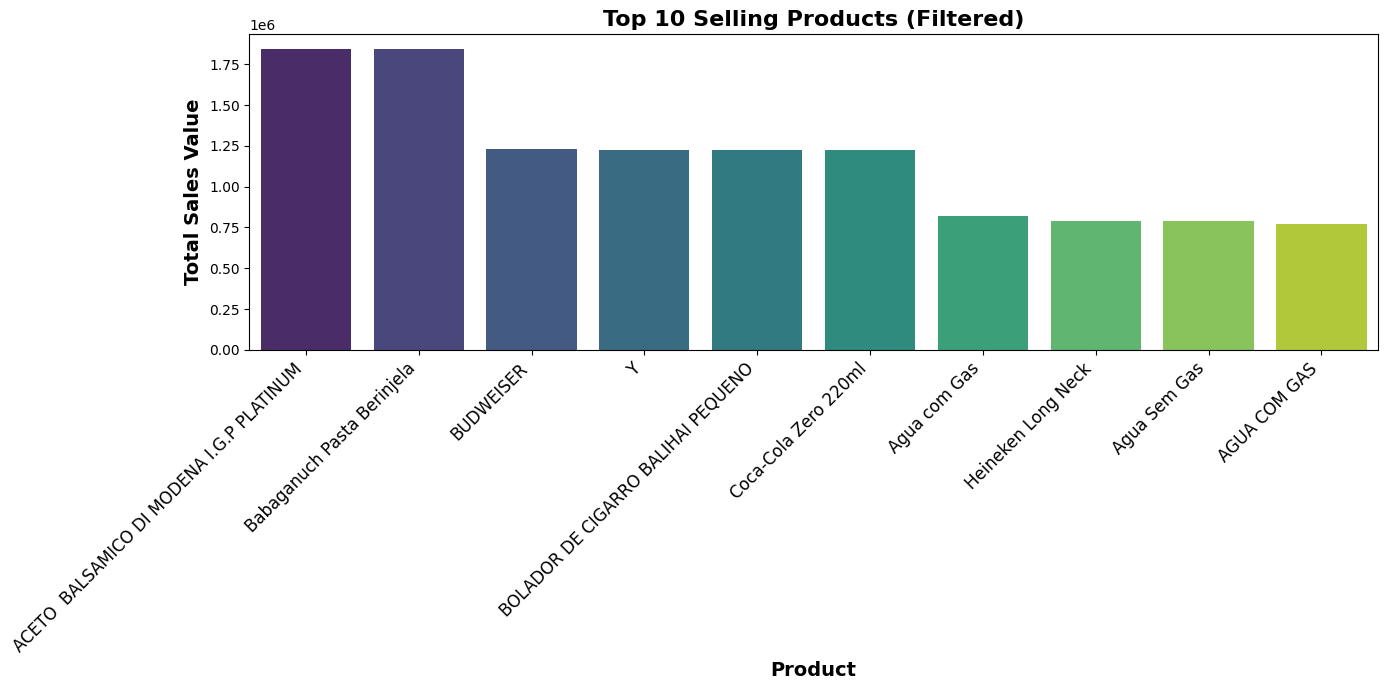

In [ ]:
top_products = filtered_sales_data.groupby('Prd_Desc')['Itm_VrUnitario'].sum().sort_values(ascending=False).head(10)

top_products_df = pd.DataFrame({
    'Product': top_products.index,
    'Total Sales Value': top_products.values
})

plt.figure(figsize=(14, 7))

sns.barplot(x='Product', y='Total Sales Value', data=top_products_df, palette='viridis')

plt.title('Top 10 Selling Products (Filtered)', fontsize=16, fontweight='bold')
plt.xlabel('Product', fontsize=14, fontweight='bold')
plt.ylabel('Total Sales Value', fontsize=14, fontweight='bold')

plt.xticks(rotation=45, ha='right', fontsize=12)

plt.tight_layout()
plt.show()

## 2.6. Filtering Sales by Day of Week

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-12-953277e596a2>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='DayOfWeek', y='Vd_VrProdutos', data=day_of_week_sales, palette='viridis')


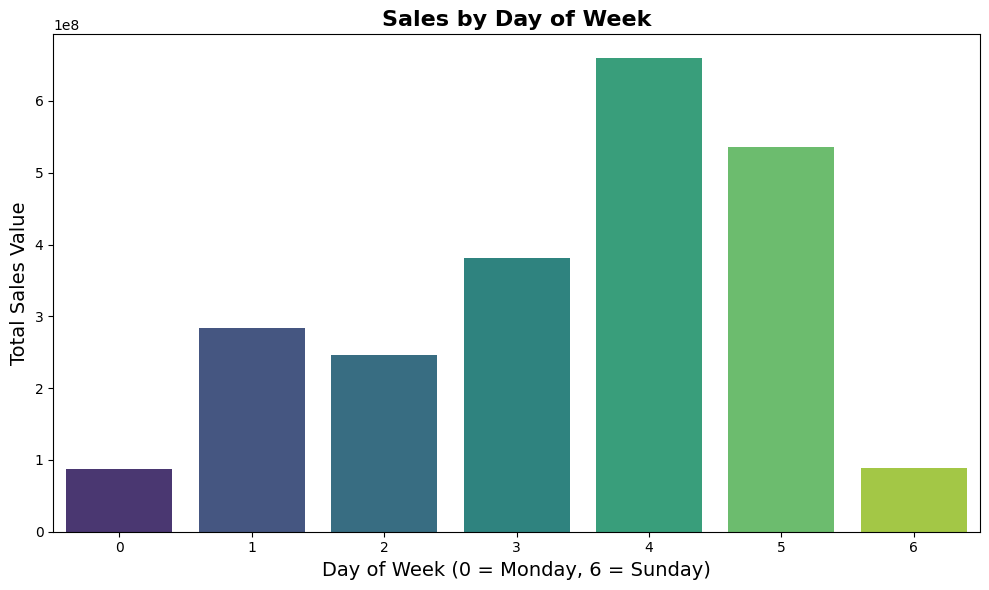

In [ ]:
sales_data['DayOfWeek'] = sales_data['Vd_DtGerencial'].dt.dayofweek

day_of_week_sales = sales_data.groupby('DayOfWeek')['Vd_VrProdutos'].sum().reset_index()

plt.figure(figsize=(10, 6))

sns.barplot(x='DayOfWeek', y='Vd_VrProdutos', data=day_of_week_sales, palette='viridis')

plt.title('Sales by Day of Week', fontsize=16, fontweight='bold')
plt.xlabel('Day of Week (0 = Monday, 6 = Sunday)', fontsize=14)
plt.ylabel('Total Sales Value', fontsize=14)

plt.tight_layout()
plt.show()

## 2.7. Number of Items oer Transaction

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-13-6b3a0748f419>:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(items_per_transaction, bins=30, kde=True, palette='viridis')


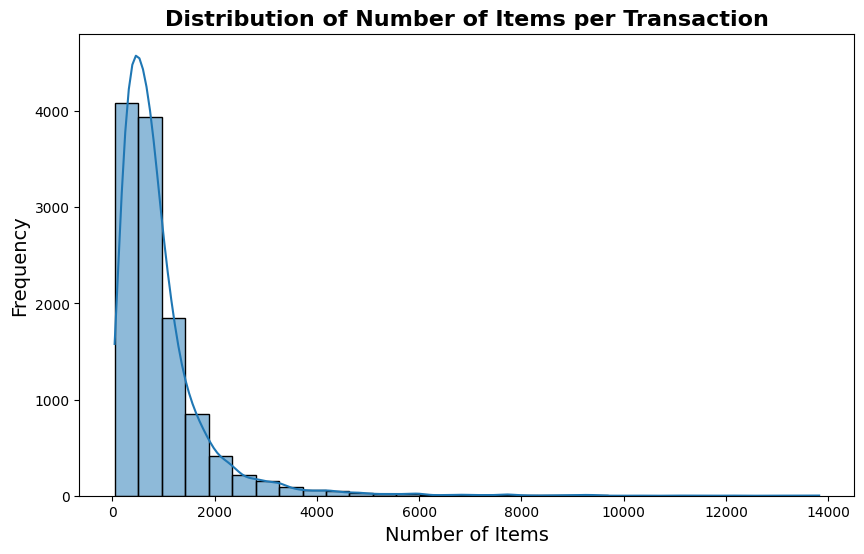

Average number of items per transaction: 936.2544008124577


In [ ]:
# Number of items per transaction
items_per_transaction = sales_data.groupby('Vd')['Prd'].count()

plt.figure(figsize=(10, 6))
sns.histplot(items_per_transaction, bins=30, kde=True, palette='viridis')
plt.title('Distribution of Number of Items per Transaction', fontsize=16, fontweight='bold')
plt.xlabel('Number of Items', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

print("Average number of items per transaction:", items_per_transaction.mean())

## 3. Exploratory Data Analsys of Transactions

In [ ]:
# Transaction list
transaction_groups = sales_data.groupby('Vd')['Prd'].apply(list).reset_index()
product_lists = transaction_groups['Prd'].tolist()

# Converting product IDs to names
product_id_to_name = produto_df.set_index('Prd')['Prd_Desc'].to_dict()
named_product_baskets = [[product_id_to_name.get(item, str(item)) for item in transaction] for transaction in product_lists]

print("Sample of named product baskets:")
print(named_product_baskets[:5])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Sample of named product baskets:
[['Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Generico', 'Gene

## 3.1. Transaction Statistics

In [ ]:
# Total number of transactions
total_transactions = len(named_product_baskets)

# Total number of products sold by summing the lengths of all baskets
total_product_count = sum(len(basket) for basket in named_product_baskets)

# Average basket size
average_basket_size = total_product_count / total_transactions

print(f"\nNumber of transactions: {total_transactions}")
print(f"Total products sold: {total_product_count}")
print(f"Average basket size: {average_basket_size:.2f}")


Number of transactions: 11816
Total products sold: 11062782
Average basket size: 936.25


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 3.2. Product Frequency Analysis

In [ ]:
all_products_list = [product for basket in named_product_baskets for product in basket]
product_frequency = Counter(all_products_list)
top_selling_products = product_frequency.most_common(20)

print("\nTop 10 most frequent products:")
for product, count in top_selling_products:
    print(f"{product}: {count}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Top 10 most frequent products:
Dose Rum San Basile Spiced: 1298080
Berinjela Em Conserva Salgada: 553420
X: 453992
Generico: 424242
Abobrinha Em Conserva: 308295
Peixinho: 277922
Pastel de Banana, Mussarela, Canela e Açúcar 31: 263934
HH Chopp da Casa: 238415
Cachaca Weber Haus Amburana Insumo: 206874
Copo Americano: 206455
Dreher Conhaque Insumo: 204480
Luva Multiuso Amarela: 189758
Arroz C/ Cordeiro: 187083
Presidente Conhaque Mel Insumo: 159432
Copo Drinck: 155490
Agua Tonica: 149952
Bobina Termica: 138444
Papel Toalha: 138123
Conhaque President: 137560
Bobina 30X40: 135600


In [ ]:
# Flattening the list of all products from all transactions into a single list
all_products_list = [product for basket in named_product_baskets for product in basket]

# Frequency of each product in the list
product_frequency = Counter(all_products_list)

# Threshold to identify high-frequency products (0.1% of most frequent)
threshold = 118160
high_frequency_products = {product for product, count in product_frequency.items() if count > threshold}

# Transactions that contain high-frequency products
filtered_baskets = [
    [product for product in basket if product not in high_frequency_products]
    for basket in named_product_baskets
]

# Transactions that became empty after filtering
filtered_baskets = [basket for basket in filtered_baskets if basket]

# Total number of transactions after filtering
total_transactions = len(filtered_baskets)

# Total number of products sold by summing the lengths of all filtered baskets
total_product_count = sum(len(basket) for basket in filtered_baskets)

# Average basket size after filtering
average_basket_size = total_product_count / total_transactions if total_transactions else 0

# Filtered metrics for number of transactions, total products sold, and average basket size
print(f"\nNumber of transactions (filtered): {total_transactions}")
print(f"Total products sold (filtered): {total_product_count}")
print(f"Average basket size (filtered): {average_basket_size:.2f}")

# Frequency of products in the filtered transactions top 10 most frequent products
filtered_product_frequency = Counter([product for basket in filtered_baskets for product in basket])
top_selling_products = filtered_product_frequency.most_common(10)

print("\nTop 10 most frequent products (filtered):")
for product, count in top_selling_products:
    print(f"{product}: {count}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Number of transactions (filtered): 9348
Total products sold (filtered): 4602403
Average basket size (filtered): 492.34

Top 10 most frequent products (filtered):
Quiabo Fritin: 114042
Cachaca 51 Insumo: 111696
Cachaca Tocoios: 109228
Embalagem P/ Viagem: 96900
Energetico Monster Tradicional: 96800
Presidente Conhaque Insumo: 95282
Bolinho de Frango com Angu e Queijo Tranca: 93810
Saco P/ Talher: 92100
Bolinho de Feijao Fradinho: 89916
Espumante Brut P/ Drinck: 88425


## 3.3. Basket Size Distribution

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


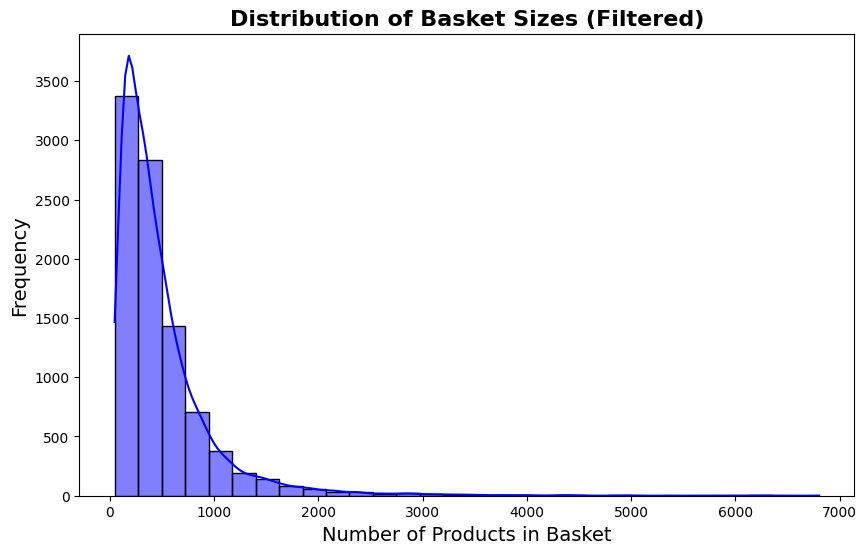


Min basket size (filtered): 47
Max basket size (filtered): 6804
Median basket size (filtered): 345.0


In [ ]:
filtered_basket_sizes = [len(basket) for basket in filtered_baskets]

plt.figure(figsize=(10, 6))
sns.histplot(filtered_basket_sizes, kde=True, bins=30, color='blue')
plt.title('Distribution of Basket Sizes (Filtered)', fontsize=16, fontweight='bold')
plt.xlabel('Number of Products in Basket', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

print(f"\nMin basket size (filtered): {min(filtered_basket_sizes)}")
print(f"Max basket size (filtered): {max(filtered_basket_sizes)}")
print(f"Median basket size (filtered): {pd.Series(filtered_basket_sizes).median()}")

## 3.4. Top 10 Most Frequent Product Pairs


Top 10 most frequent product pairs (filtered):
('Copo Descartavel 300ml', 'Tequila El Jimador'): 68
('Espumante Brut P/ Drinck', 'Louca Diversa'): 56
('Presidente Conhaque Insumo', 'Saco SOS Liso'): 53
('Cachaca 51 Insumo', 'Saco SOS Liso'): 51
('Louca Diversa', 'Presidente Conhaque Insumo'): 50
('Charuto C/ Folha De Couve Malfuf', 'Espumante Brut P/ Drinck'): 50
('Cachaca Tocoios', 'Cachaca da Casa Raiz'): 50
('Cachaca 51 Insumo', 'Espumante Brut P/ Drinck'): 49
('Cachaca 51 Insumo', 'Presidente Conhaque Insumo'): 46
('Cachaca Tocoios', 'Embalagem P/ Viagem'): 45


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-19-7a0c3d480927>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Product Pair', y='Frequency', data=top_pairs_df, palette='viridis')


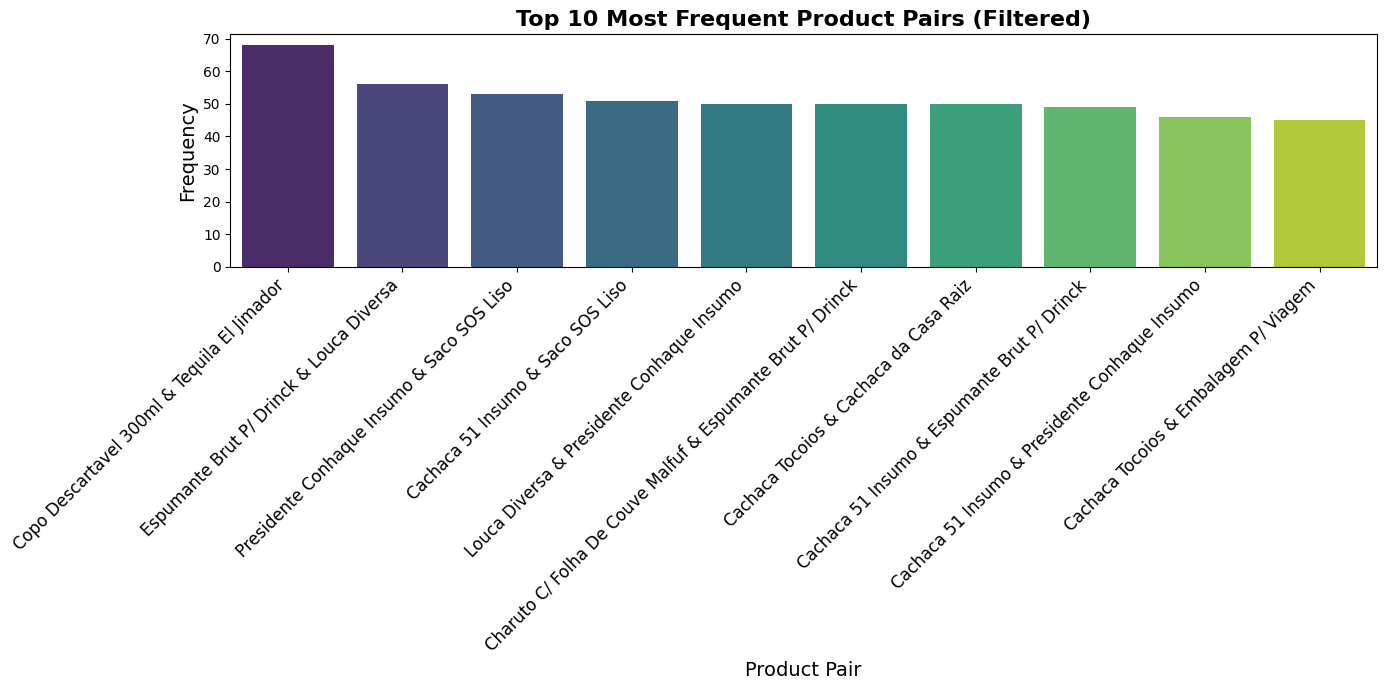

In [ ]:
product_pair_frequency = Counter()

for basket in filtered_baskets:
    product_pair_frequency.update(combinations(sorted(set(basket)), 2))

top_product_pairs = product_pair_frequency.most_common(10)

print("\nTop 10 most frequent product pairs (filtered):")
for pair, count in top_product_pairs:
    print(f"{pair}: {count}")

pairs, counts = zip(*[(f"{p[0]} & {p[1]}", c) for p, c in top_product_pairs])
top_pairs_df = pd.DataFrame({
    'Product Pair': pairs,
    'Frequency': counts
})

plt.figure(figsize=(14, 7))
sns.barplot(x='Product Pair', y='Frequency', data=top_pairs_df, palette='viridis')
plt.title('Top 10 Most Frequent Product Pairs (Filtered)', fontsize=16, fontweight='bold')
plt.xlabel('Product Pair', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()
plt.show()

## 3.5. Heatmap of Product Co-occurences

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


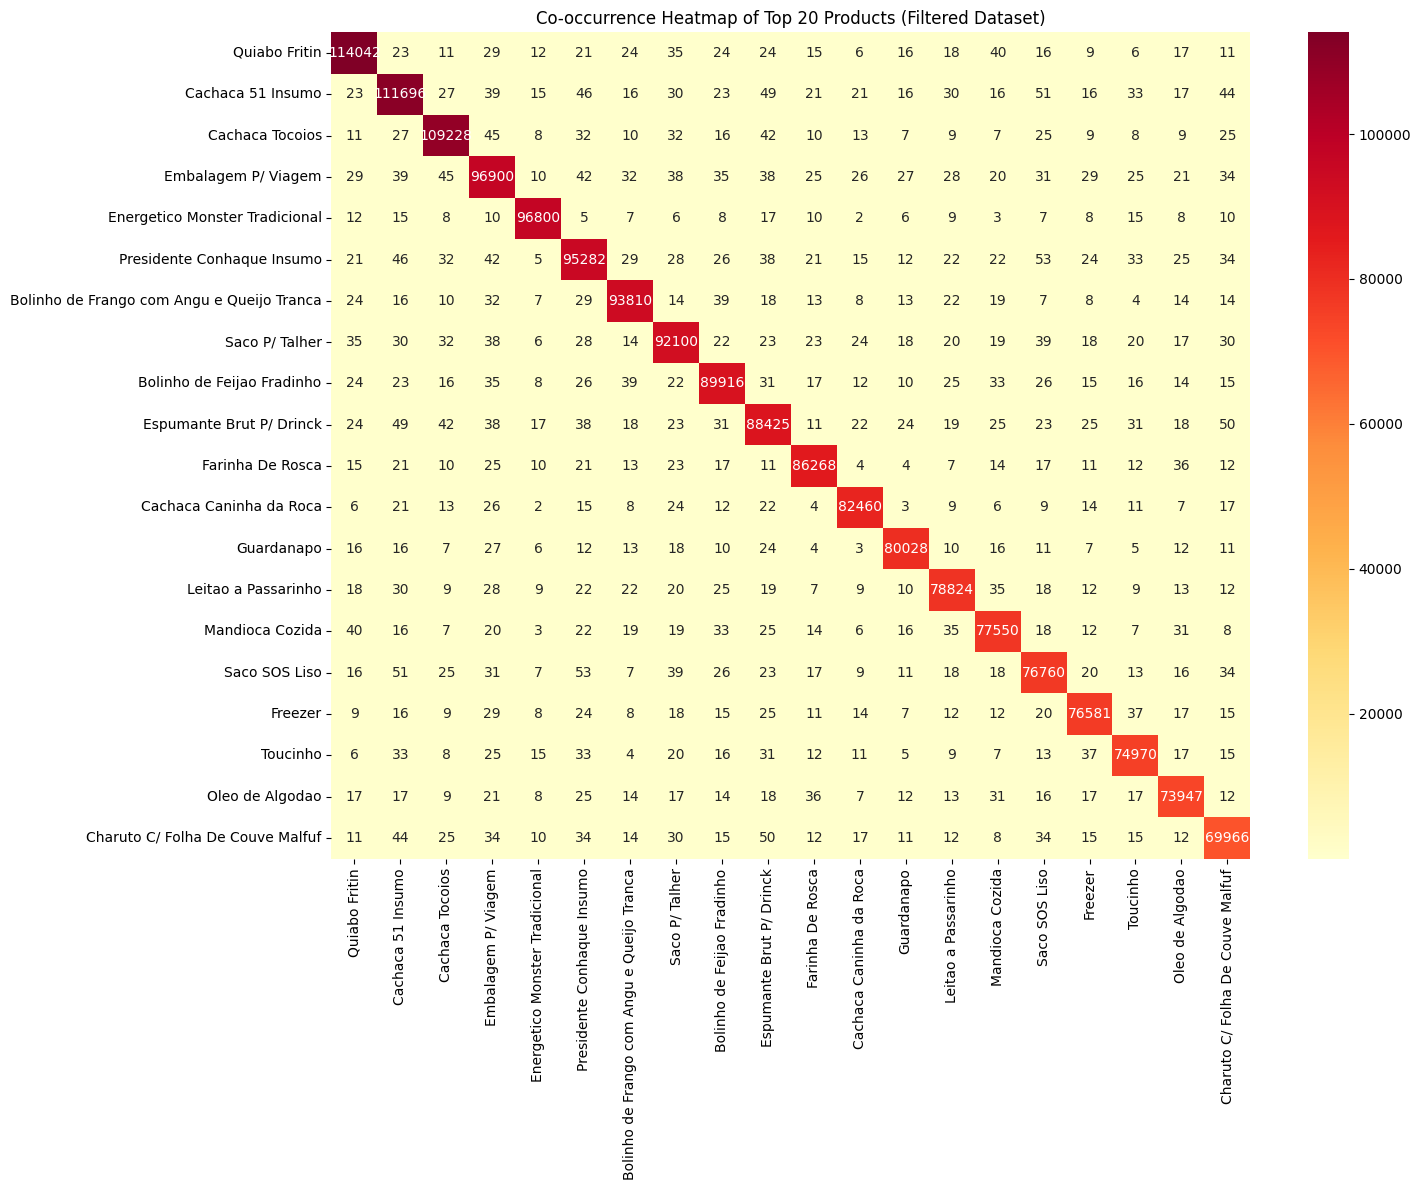

Total unique products (filtered): 262
Top 5 most frequent products (filtered):
Quiabo Fritin: 114042
Cachaca 51 Insumo: 111696
Cachaca Tocoios: 109228
Embalagem P/ Viagem: 96900
Energetico Monster Tradicional: 96800


In [ ]:
filtered_product_list = list(set([item for basket in filtered_baskets for item in basket]))

co_occurrence_matrix = pd.DataFrame(0, index=filtered_product_list, columns=filtered_product_list)

for basket in filtered_baskets:
    filtered_basket = set(basket)
    for product1, product2 in combinations(filtered_basket, 2):
        co_occurrence_matrix.loc[product1, product2] += 1
        co_occurrence_matrix.loc[product2, product1] += 1

product_freq = Counter([item for basket in filtered_baskets for item in basket])

for product in filtered_product_list:
    co_occurrence_matrix.loc[product, product] = product_freq[product]

N = 20
top_products = sorted(product_freq.items(), key=lambda x: x[1], reverse=True)[:N]
top_product_names = [product for product, _ in top_products]

plt.figure(figsize=(15, 12))
sns.heatmap(co_occurrence_matrix.loc[top_product_names, top_product_names].astype(float),
            annot=True, cmap='YlOrRd', fmt='.0f')
plt.title(f'Co-occurrence Heatmap of Top {N} Products (Filtered Dataset)')
plt.tight_layout()
plt.show()

print(f"Total unique products (filtered): {len(filtered_product_list)}")
print("Top 5 most frequent products (filtered):")
for product, freq in top_products[:5]:
    print(f"{product}: {freq}")

## 4. Association Rule Mining

### 4.1. Data Preparation


In [ ]:
# Use the filtered baskets 
filtered_baskets_based_on_product_list = [[item for item in basket if item in filtered_product_list] for basket in filtered_baskets]

print("Sample of filtered baskets based on filtered_product_list:")
print(filtered_baskets_based_on_product_list[:5])

# Transform the transaction data
te = TransactionEncoder()
te_ary = te.fit(filtered_baskets_based_on_product_list).transform(filtered_baskets_based_on_product_list)
df = pd.DataFrame(te_ary, columns=te.columns_)

print("\nTransformed data sample:")
print(df.head())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Sample of filtered baskets based on filtered_product_list:
[['Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pasta De Arich', 'Pa

### 4.2. Define Helper Functions

In [ ]:
def run_apriori(df, min_support, min_confidence):
    start_time = time.time()
    frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
    execution_time = time.time() - start_time
    return rules, execution_time

def run_fpgrowth(df, min_support, min_confidence):
    start_time = time.time()
    frequent_itemsets = fpgrowth(df, min_support=min_support, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
    execution_time = time.time() - start_time
    return rules, execution_time

def analyse_rules(rules, algorithm_name):
    print(f"\n{algorithm_name} Results:")
    print(f"Total number of rules: {len(rules)}")
    print(f"Average lift: {rules['lift'].mean():.2f}")
    print(f"Highest lift: {rules['lift'].max():.2f}")
    print(f"Average confidence: {rules['confidence'].mean():.2f}")
    print(f"Highest confidence: {rules['confidence'].max():.2f}")

def print_top_rules(rules, algorithm_name, n=10):
    print(f"\nTop {n} rules from {algorithm_name}:")
    for i, rule in rules.sort_values('lift', ascending=False).head(n).iterrows():
        antecedents = ', '.join(list(rule['antecedents']))
        consequents = ', '.join(list(rule['consequents']))
        print(f"If a customer buys: {antecedents}")
        print(f"   They are likely to also buy: {consequents}")
        print(f"   Support: {rule['support']:.4f}, Confidence: {rule['confidence']:.4f}, Lift: {rule['lift']:.4f}")
        print()

def filter_rules(rules, max_lift=10):
    filtered_rules = rules[rules['lift'] <= max_lift]
    return filtered_rules

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 4.3. Run Aprirori and FP-Growth Association

In [ ]:
# Parameters
min_support = 0.0015
min_confidence = 0.15
min_lift = 2.5

# Run Apriori
print("\nRunning Apriori algorithm...")
apriori_rules, apriori_time = run_apriori(df, min_support, min_confidence)
apriori_rules_filtered = filter_rules(apriori_rules)
apriori_rules_filtered = apriori_rules_filtered[apriori_rules_filtered['lift'] >= min_lift]
print(f"Apriori execution time: {apriori_time:.2f} seconds")
print(f"Original Apriori rules: {len(apriori_rules)}")
print(f"Filtered Apriori rules: {len(apriori_rules_filtered)}")

# Run FP-Growth
print("\nRunning FP-Growth algorithm...")
fpgrowth_rules, fpgrowth_time = run_fpgrowth(df, min_support, min_confidence)
fpgrowth_rules_filtered = filter_rules(fpgrowth_rules)
fpgrowth_rules_filtered = fpgrowth_rules_filtered[fpgrowth_rules_filtered['lift'] >= min_lift]
print(f"FP-Growth execution time: {fpgrowth_time:.2f} seconds")
print(f"Original FP-Growth rules: {len(fpgrowth_rules)}")
print(f"Filtered FP-Growth rules: {len(fpgrowth_rules_filtered)}")


Running Apriori algorithm...


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Apriori execution time: 1.46 seconds
Original Apriori rules: 34
Filtered Apriori rules: 26

Running FP-Growth algorithm...
FP-Growth execution time: 0.51 seconds
Original FP-Growth rules: 34
Filtered FP-Growth rules: 26


### 4.4. Analys Results

In [ ]:
# Analyse and print top rules for both algorithms
analyse_rules(apriori_rules_filtered, "Apriori")
print_top_rules(apriori_rules_filtered, "Apriori")

analyse_rules(fpgrowth_rules_filtered, "FP-Growth")
print_top_rules(fpgrowth_rules_filtered, "FP-Growth")

# Print lift statistics
print("\nApriori Lift Statistics:")
print(apriori_rules_filtered['lift'].describe())

print("\nFP-Growth Lift Statistics:")
print(fpgrowth_rules_filtered['lift'].describe())

# Print top 5 rules by lift
print("\nTop 5 Apriori Rules by Lift:")
print(apriori_rules_filtered.sort_values('lift', ascending=False).head().to_string(index=False))

print("\nTop 5 FP-Growth Rules by Lift:")
print(fpgrowth_rules_filtered.sort_values('lift', ascending=False).head().to_string(index=False))

# Compare number of rules
print("\nNumber of Rules Comparison:")
print(f"Apriori: {len(apriori_rules_filtered)}")
print(f"FP-Growth: {len(fpgrowth_rules_filtered)}")

# Calculate rule overlap
apriori_rules_set = set(map(frozenset, zip(apriori_rules_filtered['antecedents'], apriori_rules_filtered['consequents'])))
fpgrowth_rules_set = set(map(frozenset, zip(fpgrowth_rules_filtered['antecedents'], fpgrowth_rules_filtered['consequents'])))

print("\nRule Overlap:")
print(f"Rules common to both algorithms: {len(apriori_rules_set & fpgrowth_rules_set)}")


Apriori Results:
Total number of rules: 26
Average lift: 5.79
Highest lift: 9.88
Average confidence: 0.21
Highest confidence: 0.36

Top 10 rules from Apriori:
If a customer buys: Cerveja da Casa Puro Malte
   They are likely to also buy: Campari Insumo
   Support: 0.0019, Confidence: 0.2368, Lift: 9.8839

If a customer buys: Cachaca Pitu de Garrafa
   They are likely to also buy: Pilha
   Support: 0.0018, Confidence: 0.2125, Lift: 9.8828

If a customer buys: Cachaca da Casa Raiz
   They are likely to also buy: Cachaca Tocoios
   Support: 0.0053, Confidence: 0.3597, Lift: 9.3405

If a customer buys: Tequila El Jimador
   They are likely to also buy: Copo Descartavel 300ml
   Support: 0.0073, Confidence: 0.3091, Lift: 9.0861

If a customer buys: Copo Descartavel 300ml
   They are likely to also buy: Tequila El Jimador
   Support: 0.0073, Confidence: 0.2138, Lift: 9.0861

If a customer buys: Cachaca Pitu de Garrafa
   They are likely to also buy: Cachaca Tocoios
   Support: 0.0028, Confi

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 4.5. Visualise Results

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-25-19c2336d73d0>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


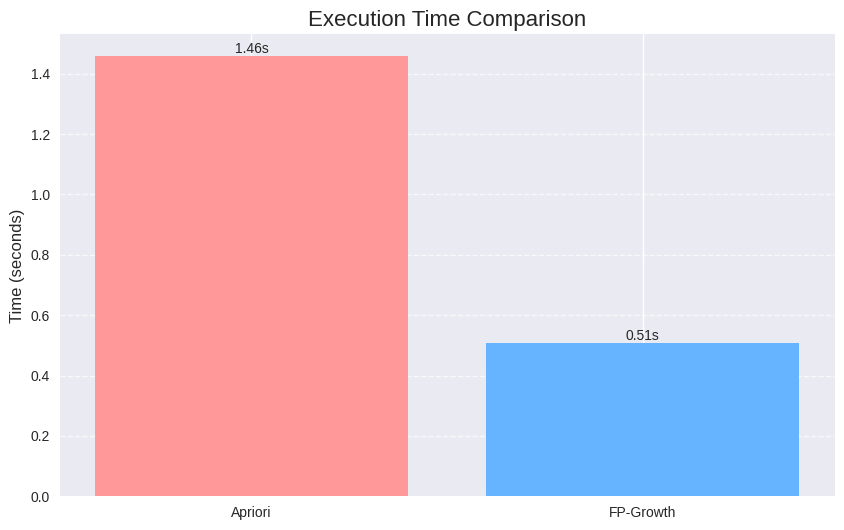

<ipython-input-25-19c2336d73d0>:20: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(apriori_rules_filtered['lift'], shade=True, color='#ff9999', ax=ax1)
<ipython-input-25-19c2336d73d0>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(fpgrowth_rules_filtered['lift'], shade=True, color='#66b3ff', ax=ax2)


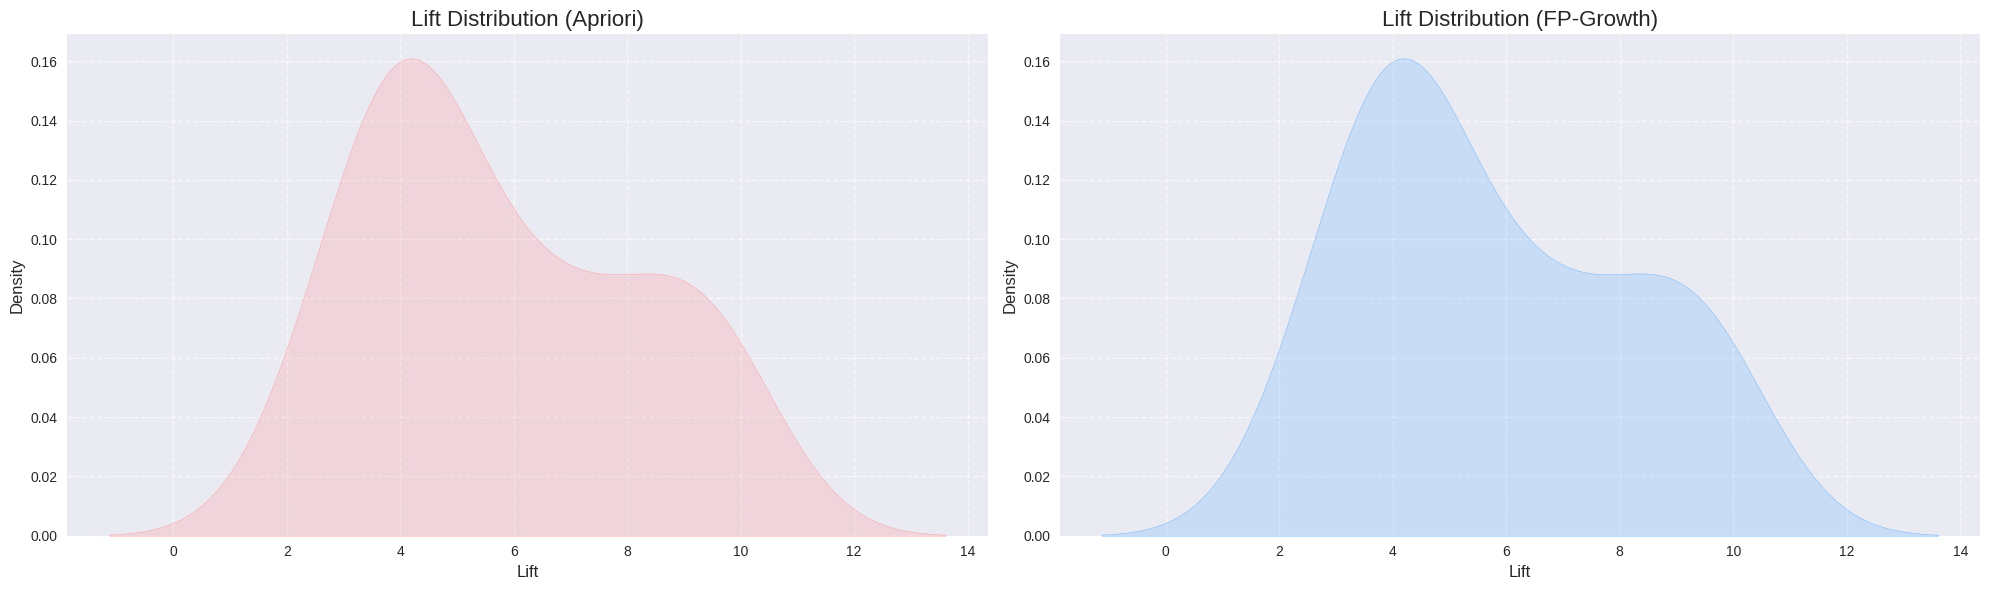

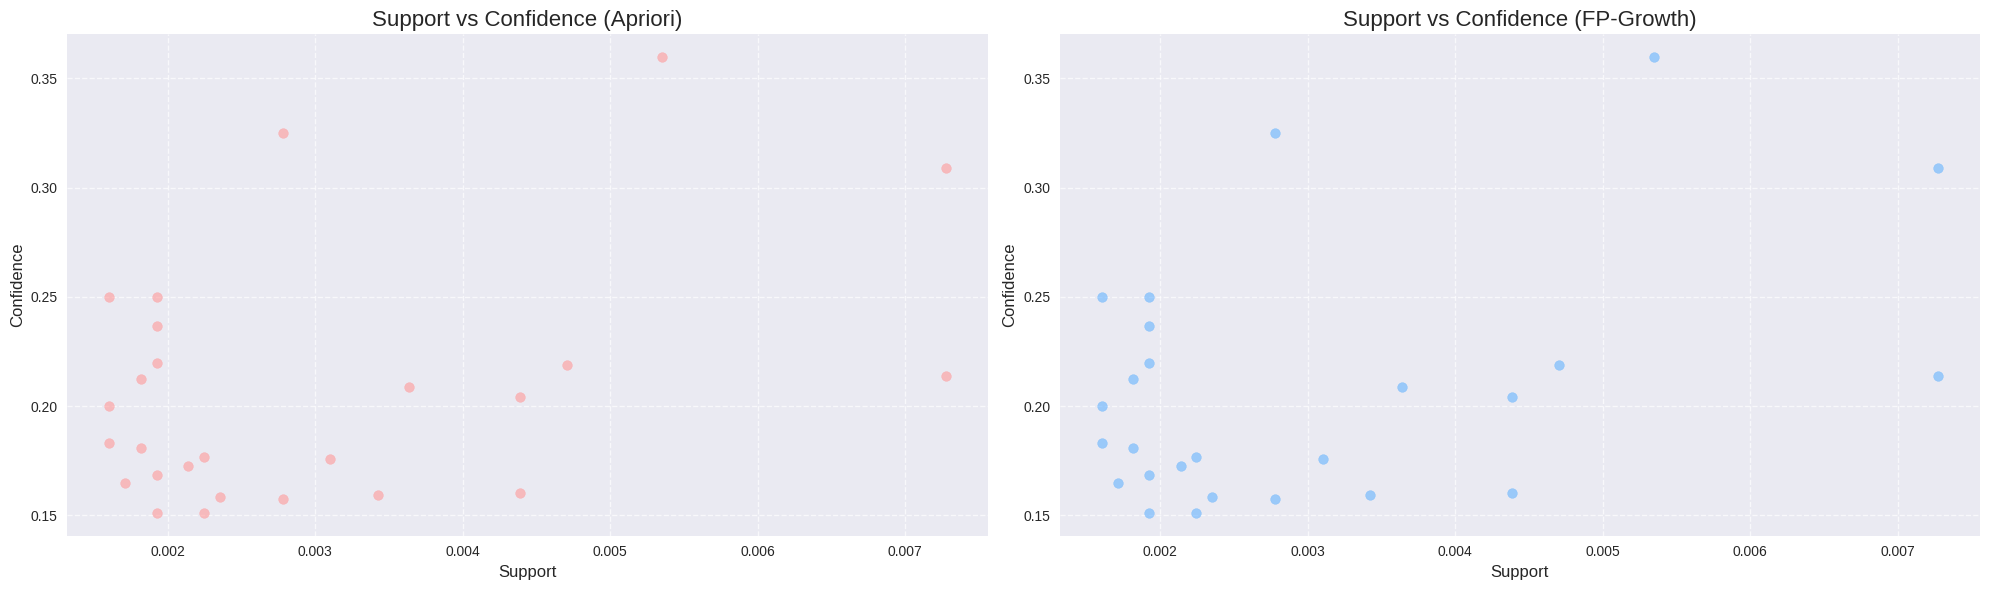

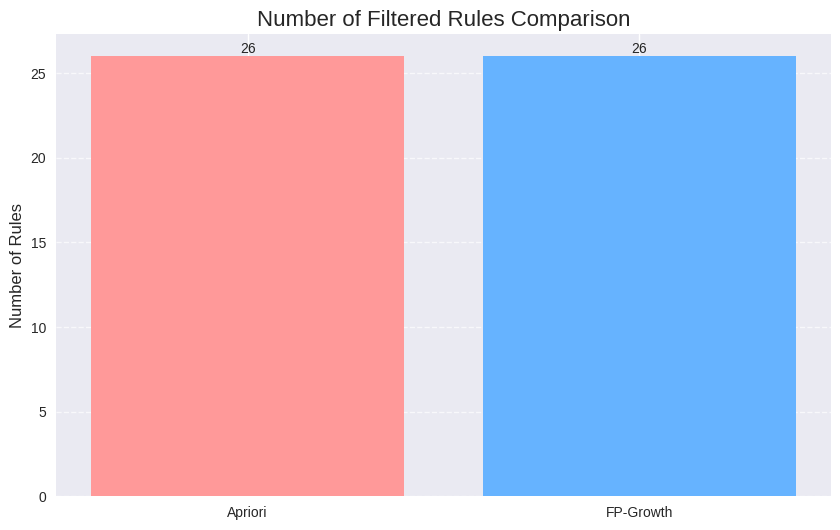

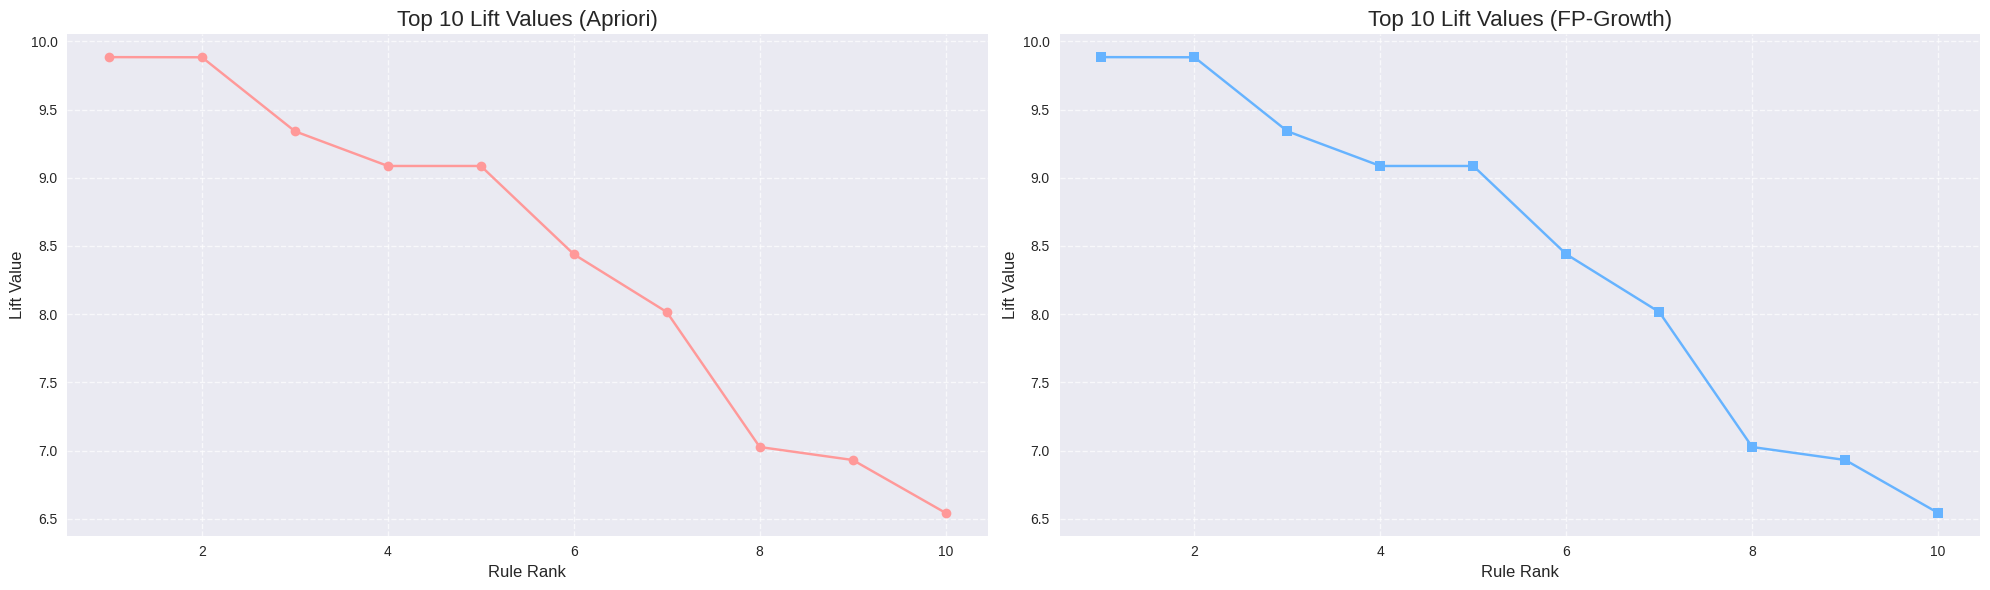

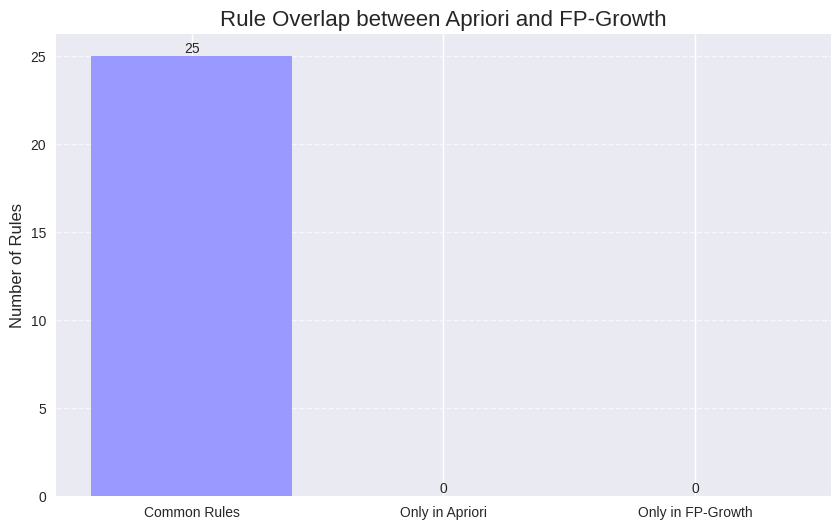

In [ ]:
plt.style.use('seaborn')
sns.set_palette("Set2")

# Execution Time Comparison
plt.figure(figsize=(10, 6))
bars = plt.bar(['Apriori', 'FP-Growth'], [apriori_time, fpgrowth_time], color=['#ff9999', '#66b3ff'])
plt.title('Execution Time Comparison', fontsize=16)
plt.ylabel('Time (seconds)', fontsize=12)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}s',
             ha='center', va='bottom')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Lift Distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

sns.kdeplot(apriori_rules_filtered['lift'], shade=True, color='#ff9999', ax=ax1)
ax1.set_title('Lift Distribution (Apriori)', fontsize=16)
ax1.set_xlabel('Lift', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)
ax1.grid(linestyle='--', alpha=0.7)

sns.kdeplot(fpgrowth_rules_filtered['lift'], shade=True, color='#66b3ff', ax=ax2)
ax2.set_title('Lift Distribution (FP-Growth)', fontsize=16)
ax2.set_xlabel('Lift', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.grid(linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Support vs Confidence Scatter Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

ax1.scatter(apriori_rules_filtered['support'], apriori_rules_filtered['confidence'],
            alpha=0.6, color='#ff9999')
ax1.set_title('Support vs Confidence (Apriori)', fontsize=16)
ax1.set_xlabel('Support', fontsize=12)
ax1.set_ylabel('Confidence', fontsize=12)
ax1.grid(linestyle='--', alpha=0.7)

ax2.scatter(fpgrowth_rules_filtered['support'], fpgrowth_rules_filtered['confidence'],
            alpha=0.6, color='#66b3ff')
ax2.set_title('Support vs Confidence (FP-Growth)', fontsize=16)
ax2.set_xlabel('Support', fontsize=12)
ax2.set_ylabel('Confidence', fontsize=12)
ax2.grid(linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Number of Rules Comparison
plt.figure(figsize=(10, 6))
bars = plt.bar(['Apriori', 'FP-Growth'],
               [len(apriori_rules_filtered), len(fpgrowth_rules_filtered)],
               color=['#ff9999', '#66b3ff'])
plt.title('Number of Filtered Rules Comparison', fontsize=16)
plt.ylabel('Number of Rules', fontsize=12)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height}',
             ha='center', va='bottom')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Top 10 Lift Values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

apriori_top_10 = apriori_rules_filtered.nlargest(10, 'lift')['lift']
ax1.plot(range(1, 11), apriori_top_10, 'o-', color='#ff9999')
ax1.set_title('Top 10 Lift Values (Apriori)', fontsize=16)
ax1.set_xlabel('Rule Rank', fontsize=12)
ax1.set_ylabel('Lift Value', fontsize=12)
ax1.grid(linestyle='--', alpha=0.7)

fpgrowth_top_10 = fpgrowth_rules_filtered.nlargest(10, 'lift')['lift']
ax2.plot(range(1, 11), fpgrowth_top_10, 's-', color='#66b3ff')
ax2.set_title('Top 10 Lift Values (FP-Growth)', fontsize=16)
ax2.set_xlabel('Rule Rank', fontsize=12)
ax2.set_ylabel('Lift Value', fontsize=12)
ax2.grid(linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Rule Overlap Visualization
apriori_rules_set = set(map(frozenset, zip(apriori_rules_filtered['antecedents'], apriori_rules_filtered['consequents'])))
fpgrowth_rules_set = set(map(frozenset, zip(fpgrowth_rules_filtered['antecedents'], fpgrowth_rules_filtered['consequents'])))
common_rules = len(apriori_rules_set & fpgrowth_rules_set)
only_apriori = len(apriori_rules_set) - common_rules
only_fpgrowth = len(fpgrowth_rules_set) - common_rules

plt.figure(figsize=(10, 6))
plt.bar(['Common Rules', 'Only in Apriori', 'Only in FP-Growth'],
        [common_rules, only_apriori, only_fpgrowth],
        color=['#9999ff', '#ff9999', '#66b3ff'])
plt.title('Rule Overlap between Apriori and FP-Growth', fontsize=16)
plt.ylabel('Number of Rules', fontsize=12)
for i, v in enumerate([common_rules, only_apriori, only_fpgrowth]):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 4.6. Hyperparameter Analysis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Summary of Results:
 min_support  min_confidence  apriori_rules  apriori_time  fpgrowth_rules  fpgrowth_time  apriori_avg_lift  fpgrowth_avg_lift
      0.0010            0.10            217      2.796979             217       0.515314          6.315582           6.315582
      0.0020            0.15             19      1.017897              19       0.101244          8.204913           8.204913
      0.0015            0.20             19      1.399954              19       0.105960         10.887424          10.887424
      0.0005            0.25            423      8.634435             423       0.560697         17.281667          17.281667
      0.0030            0.05            144      0.637463             144       0.095288          2.399211           2.399211


<ipython-input-26-5274519037e6>:59: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


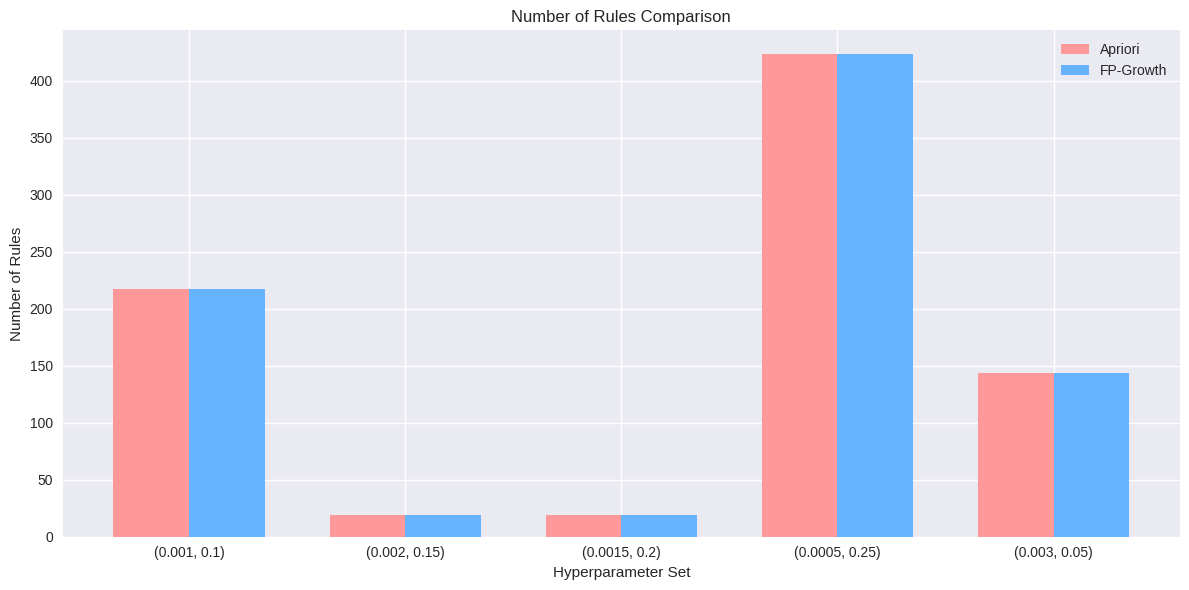

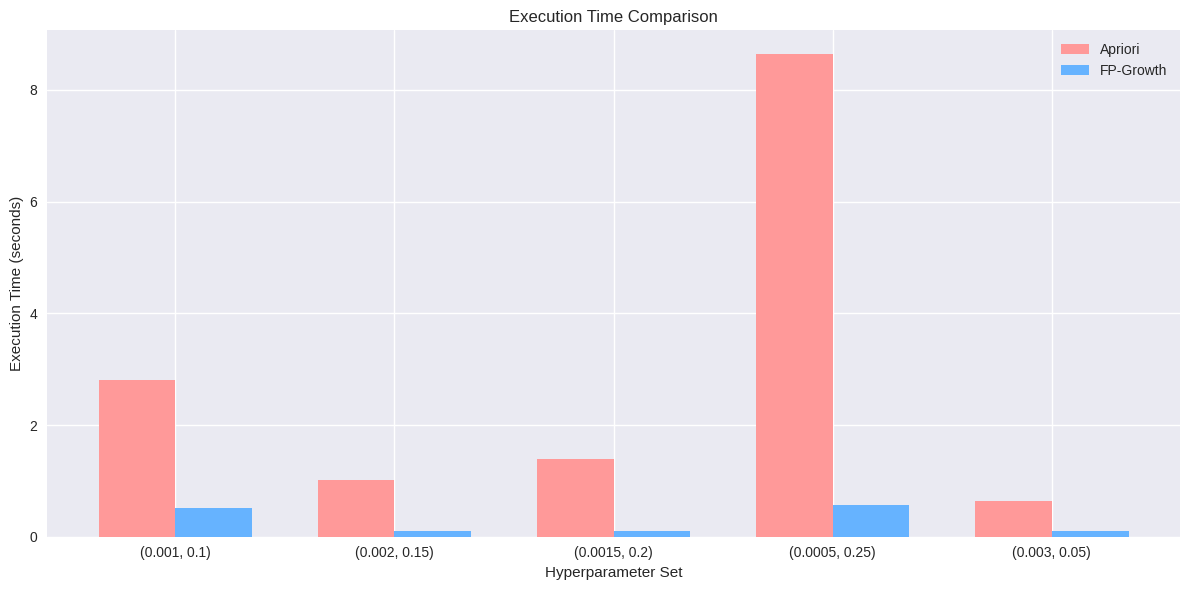

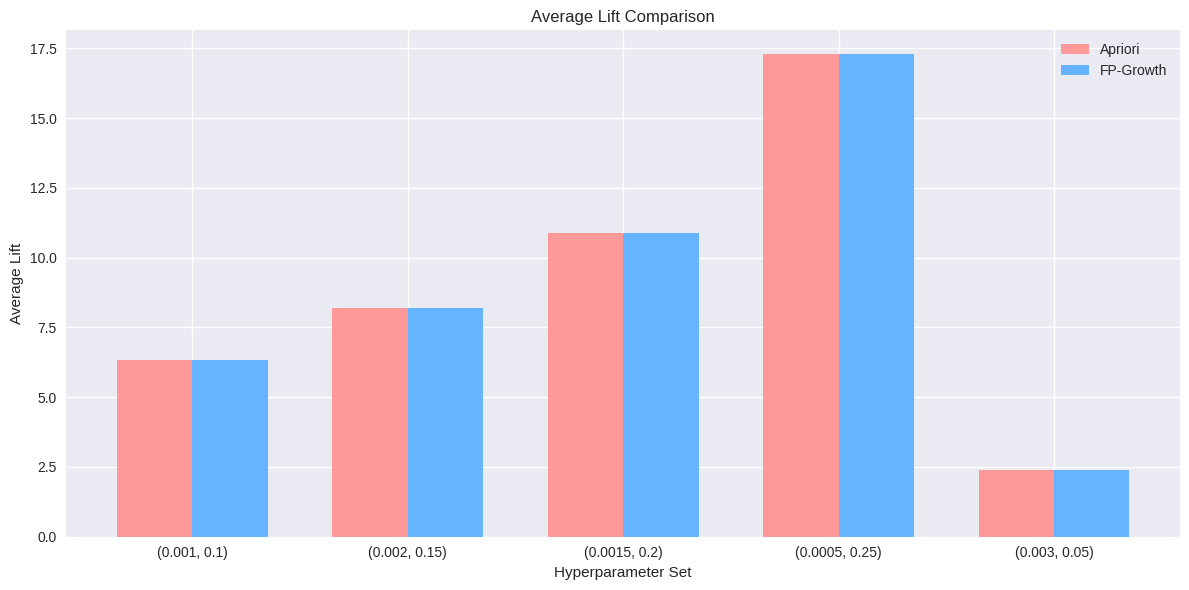

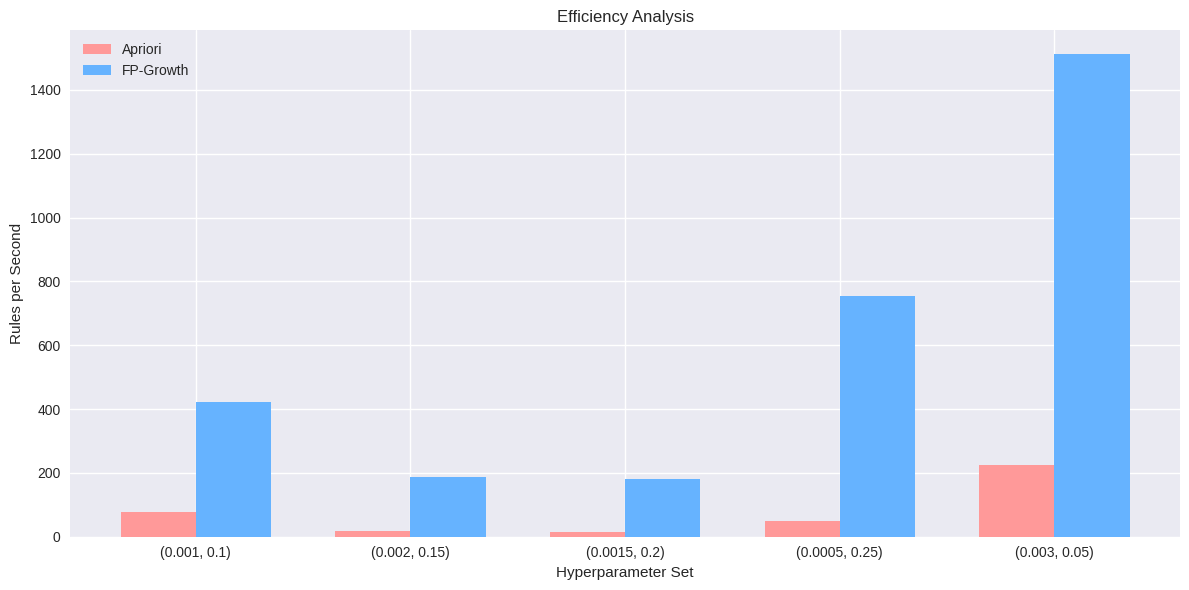

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules

# Define hyperparameter combinations
hyperparameters = [
    (0.001, 0.10),  # Low support, moderate confidence
    (0.002, 0.15),  # Slightly higher support, moderate confidence
    (0.0015, 0.20),  # Intermediate support, higher confidence
    (0.0005, 0.25),  # Very low support, high confidence
    (0.003, 0.05),   # Higher support, low confidence
]

# Function to run experiment and return results
def run_experiment(df, min_support, min_confidence):
    # Apriori
    start_time = time.time()
    apriori_frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True)
    apriori_rules = association_rules(apriori_frequent_itemsets, metric="confidence", min_threshold=min_confidence)
    apriori_time = time.time() - start_time

    # FP-Growth
    start_time = time.time()
    fpgrowth_frequent_itemsets = fpgrowth(df, min_support=min_support, use_colnames=True)
    fpgrowth_rules = association_rules(fpgrowth_frequent_itemsets, metric="confidence", min_threshold=min_confidence)
    fpgrowth_time = time.time() - start_time

    return {
        'min_support': min_support,
        'min_confidence': min_confidence,
        'apriori_rules': len(apriori_rules),
        'apriori_time': apriori_time,
        'fpgrowth_rules': len(fpgrowth_rules),
        'fpgrowth_time': fpgrowth_time,
        'apriori_avg_lift': apriori_rules['lift'].mean() if len(apriori_rules) > 0 else 0,
        'fpgrowth_avg_lift': fpgrowth_rules['lift'].mean() if len(fpgrowth_rules) > 0 else 0,
    }, apriori_rules, fpgrowth_rules

# Run experiments
results = []
all_apriori_rules = []
all_fpgrowth_rules = []
for min_support, min_confidence in hyperparameters:
    result, apriori_rules, fpgrowth_rules = run_experiment(df, min_support, min_confidence)
    results.append(result)
    all_apriori_rules.append(apriori_rules)
    all_fpgrowth_rules.append(fpgrowth_rules)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Print summary
print("Summary of Results:")
print(results_df.to_string(index=False))

# Visualisations
plt.style.use('seaborn')
sns.set_palette("Set2")

# 1. Number of Rules Comparison
plt.figure(figsize=(12, 6))
x = range(len(hyperparameters))
width = 0.35
plt.bar(x, results_df['apriori_rules'], width, label='Apriori', color='#ff9999')
plt.bar([i + width for i in x], results_df['fpgrowth_rules'], width, label='FP-Growth', color='#66b3ff')
plt.xlabel('Hyperparameter Set')
plt.ylabel('Number of Rules')
plt.title('Number of Rules Comparison')
plt.xticks([i + width/2 for i in x], [f'({s}, {c})' for s, c in hyperparameters])
plt.legend()
plt.tight_layout()
plt.show()

# 2. Execution Time Comparison
plt.figure(figsize=(12, 6))
plt.bar(x, results_df['apriori_time'], width, label='Apriori', color='#ff9999')
plt.bar([i + width for i in x], results_df['fpgrowth_time'], width, label='FP-Growth', color='#66b3ff')
plt.xlabel('Hyperparameter Set')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time Comparison')
plt.xticks([i + width/2 for i in x], [f'({s}, {c})' for s, c in hyperparameters])
plt.legend()
plt.tight_layout()
plt.show()

# 3. Average Lift Comparison
plt.figure(figsize=(12, 6))
plt.bar(x, results_df['apriori_avg_lift'], width, label='Apriori', color='#ff9999')
plt.bar([i + width for i in x], results_df['fpgrowth_avg_lift'], width, label='FP-Growth', color='#66b3ff')
plt.xlabel('Hyperparameter Set')
plt.ylabel('Average Lift')
plt.title('Average Lift Comparison')
plt.xticks([i + width/2 for i in x], [f'({s}, {c})' for s, c in hyperparameters])
plt.legend()
plt.tight_layout()
plt.show()

# 4. Efficiency Analysis (Rules per Second)
results_df['apriori_efficiency'] = results_df['apriori_rules'] / results_df['apriori_time']
results_df['fpgrowth_efficiency'] = results_df['fpgrowth_rules'] / results_df['fpgrowth_time']

plt.figure(figsize=(12, 6))
plt.bar(x, results_df['apriori_efficiency'], width, label='Apriori', color='#ff9999')
plt.bar([i + width for i in x], results_df['fpgrowth_efficiency'], width, label='FP-Growth', color='#66b3ff')
plt.xlabel('Hyperparameter Set')
plt.ylabel('Rules per Second')
plt.title('Efficiency Analysis')
plt.xticks([i + width/2 for i in x], [f'({s}, {c})' for s, c in hyperparameters])
plt.legend()
plt.tight_layout()
plt.show()

## 4.7. Rules for Best Parameters

In [ ]:
def print_rules(rules, algorithm_name, n=3, rule_type="top"):
    if rule_type == "top":
        selected_rules = rules.sort_values('lift', ascending=False).head(n)
        print(f"\nTop {n} rules for {algorithm_name}:")
    elif rule_type == "average":
        mean_lift = rules['lift'].mean()
        selected_rules = rules.iloc[(rules['lift'] - mean_lift).abs().argsort()[:n]]
        print(f"\n{n} Average rules for {algorithm_name} (mean lift: {mean_lift:.4f}):")

    for i, (index, rule) in enumerate(selected_rules.iterrows(), 1):
        antecedents = ', '.join(list(rule['antecedents']))
        consequents = ', '.join(list(rule['consequents']))
        print(f"{i}. {antecedents} -> {consequents}")
        print(f"   Support: {rule['support']:.4f}, Confidence: {rule['confidence']:.4f}, Lift: {rule['lift']:.4f}")

# Print top and average rules for each set of parameters
for i, (min_support, min_confidence) in enumerate(hyperparameters):
    print(f"\n\nResults for min_support={min_support}, min_confidence={min_confidence}:")
    print(f"Total rules: {len(all_apriori_rules[i])}")
    print_rules(all_apriori_rules[i], "Apriori", n=3, rule_type="top")
    print_rules(all_apriori_rules[i], "Apriori", n=3, rule_type="average")

    if (min_support, min_confidence) == (0.001, 0.10):
        print("\n# Low support, moderate confidence:")
        print("# - Captures rare associations with reasonable reliability")
        print("# - May provide a good balance between quantity and quality of rules")
    elif (min_support, min_confidence) == (0.002, 0.15):
        print("\n# Balanced approach:")
        print("# - Moderately low support, moderate confidence")
        print("# - Aims for a sweet spot between frequency and reliability")
    elif (min_support, min_confidence) == (0.0015, 0.20):
        print("\n# Intermediate support, higher confidence:")
        print("# - Focuses on more reliable associations")
        print("# - May provide a good trade-off between support and confidence")
    elif (min_support, min_confidence) == (0.0005, 0.25):
        print("\n# Very low support, high confidence:")
        print("# - Allows for discovery of very rare but strong associations")
        print("# - May uncover niche patterns in the data")
    elif (min_support, min_confidence) == (0.003, 0.05):
        print("\n# Higher support, low confidence:")
        print("# - Focuses on more frequent itemsets")
        print("# - May reveal broader trends but with lower reliability")



Results for min_support=0.001, min_confidence=0.1:
Total rules: 217

Top 3 rules for Apriori:
1. Banha -> Papel Sulfite
   Support: 0.0011, Confidence: 0.2326, Lift: 42.6265
2. Papel Sulfite -> Banha
   Support: 0.0011, Confidence: 0.1961, Lift: 42.6265
3. Arroz C/ Lentilha Mijadra -> Energetico Red Bull
   Support: 0.0019, Confidence: 0.1169, Lift: 32.1360

3 Average rules for Apriori (mean lift: 6.3156):
1. Coca Cola Lata -> Campari Insumo
   Support: 0.0011, Confidence: 0.1515, Lift: 6.3231
2. Adicional Calabresa -> Toucinho
   Support: 0.0019, Confidence: 0.2500, Lift: 6.3333
3. Pastel de Palmito Montado -> Toucinho
   Support: 0.0011, Confidence: 0.2500, Lift: 6.3333

# Low support, moderate confidence:
# - Captures rare associations with reasonable reliability
# - May provide a good balance between quantity and quality of rules


Results for min_support=0.002, min_confidence=0.15:
Total rules: 19

Top 3 rules for Apriori:
1. Cachaca da Casa Raiz -> Cachaca Pitu de Garrafa
   Su

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 5. Pipeline for Emp 1.

In [ ]:
# Data Preparation
emp_id = 1
sales_data = pd.merge(venda_df[venda_df['Emp'] == emp_id], vendaitem_df[vendaitem_df['Emp'] == emp_id], on=['Emp', 'Vd'])
sales_data = pd.merge(sales_data, produto_df[['Prd', 'Prd_Desc']], on='Prd')
sales_data['Vd_DtGerencial'] = pd.to_datetime(sales_data['Vd_DtGerencial'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Basic EDA for Employee 1
Total number of transactions: 2556
Average items per transaction: 229.20
Number of unique products sold: 30
Date range: 2021-01-04 00:00:00 to 2024-02-02 00:00:00

Top 10 most common products:
Prd_Desc
X                                            28069
Generico                                     15919
Babaganuch Pasta Berinjela                    7476
ACETO  BALSAMICO DI MODENA I.G.P PLATINUM     7476
BUDWEISER                                     4996
Coca-Cola Zero 220ml                          4984
BOLADOR DE CIGARRO BALIHAI PEQUENO            4984
Y                                             4984
Heineken Long Neck                            3007
RED BULL                                      2931
Name: count, dtype: int64

Top 10 most common products:
X: 28069
Generico: 15919
Babaganuch Pasta Berinjela: 7476
ACETO  BALSAMICO DI MODENA I.G.P PLATINUM: 7476
BUDWEISER: 4996
Coca-Cola Zero 220ml: 4984
BOLADOR DE CIGARRO BALIHAI PEQUENO: 4984
Y: 4984
Heineken

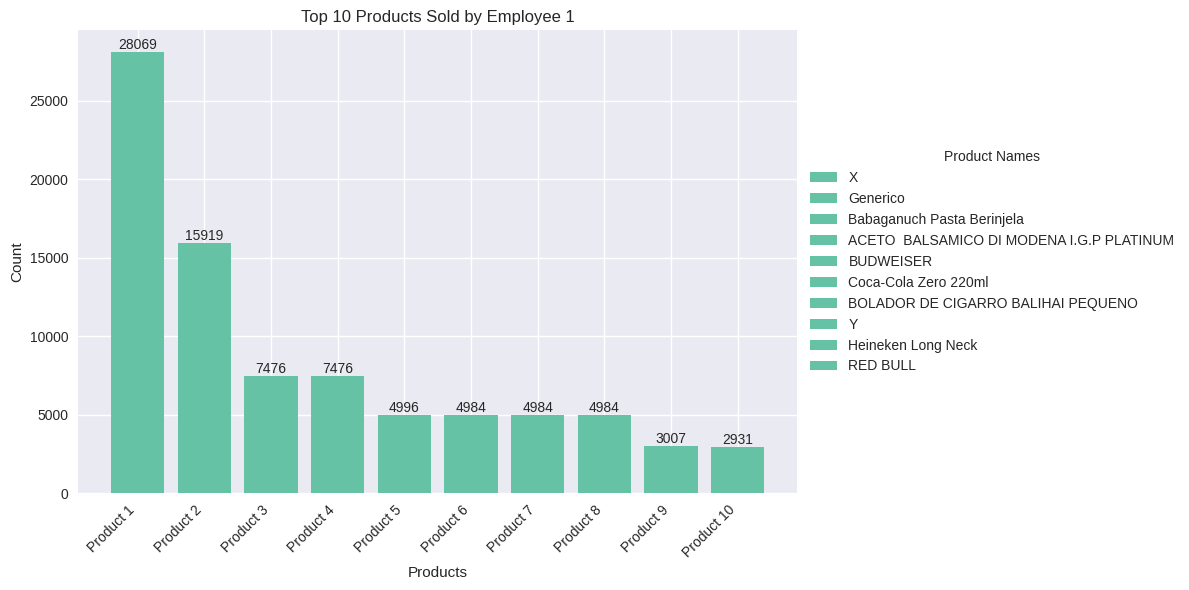


Product Name Reference:
Product 1: X
Product 2: Generico
Product 3: Babaganuch Pasta Berinjela
Product 4: ACETO  BALSAMICO DI MODENA I.G.P PLATINUM
Product 5: BUDWEISER
Product 6: Coca-Cola Zero 220ml
Product 7: BOLADOR DE CIGARRO BALIHAI PEQUENO
Product 8: Y
Product 9: Heineken Long Neck
Product 10: RED BULL


In [ ]:
# Basic EDA
print(f"\nBasic EDA for Employee {emp_id}")
print(f"Total number of transactions: {sales_data['Vd'].nunique()}")
print(f"Average items per transaction: {sales_data.groupby('Vd')['Prd'].count().mean():.2f}")
print(f"Number of unique products sold: {sales_data['Prd'].nunique()}")
print(f"Date range: {sales_data['Vd_DtGerencial'].min()} to {sales_data['Vd_DtGerencial'].max()}")

top_products = sales_data['Prd_Desc'].value_counts().head(10)
print("\nTop 10 most common products:")
print(top_products)

# Top products analysis
top_products = sales_data['Prd_Desc'].value_counts().head(10)
print("\nTop 10 most common products:")
for product, count in top_products.items():
    print(f"{product}: {count}")

plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(top_products)), top_products.values)
plt.title(f'Top 10 Products Sold by Employee {emp_id}')
plt.xlabel('Products')
plt.ylabel('Count')

for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f'{bar.get_height()}',
             ha='center', va='bottom')

plt.xticks(range(len(top_products)),
           [f'Product {i+1}' for i in range(len(top_products))],
           rotation=45, ha='right')

plt.legend(bars, top_products.index, title='Product Names',
           loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

print("\nProduct Name Reference:")
for i, product in enumerate(top_products.index, 1):
    print(f"Product {i}: {product}")

In [ ]:
# Transaction Analysis and Filtering
transaction_groups = sales_data.groupby('Vd')['Prd_Desc'].apply(list).reset_index()
baskets = transaction_groups['Prd_Desc'].tolist()

baskets = [[str(item) for item in basket] for basket in baskets]

all_products = [item for basket in baskets for item in basket]
product_frequency = Counter(all_products)

total_transactions = len(baskets)
average_basket_size = sum(len(basket) for basket in baskets) / total_transactions

print(f"\nNumber of transactions: {total_transactions}")
print(f"Average basket size: {average_basket_size:.2f}")

print("\nTop 10 most frequent products:")
for product, count in product_frequency.most_common(10):
    print(f"{product}: {count}")

# Set threshold for high-frequency products
threshold = 10000

# Identify high-frequency products
high_frequency_products = {product for product, count in product_frequency.items() if count > threshold}

# Filter out high-frequency products from the baskets
filtered_baskets = [
    [product for product in basket if product not in high_frequency_products]
    for basket in baskets
]
filtered_baskets = [basket for basket in filtered_baskets if basket]  # Remove empty baskets

# Recalculate statistics after filtering
filtered_total_transactions = len(filtered_baskets)
filtered_average_basket_size = sum(len(basket) for basket in filtered_baskets) / filtered_total_transactions if filtered_total_transactions > 0 else 0

print(f"\nNumber of transactions after filtering: {filtered_total_transactions}")
print(f"Average basket size after filtering: {filtered_average_basket_size:.2f}")

filtered_product_frequency = Counter([item for basket in filtered_baskets for item in basket])
print("\nTop 10 most frequent products after filtering:")
for product, count in filtered_product_frequency.most_common(10):
    print(f"{product}: {count}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Number of transactions: 2556
Average basket size: 229.20

Top 10 most frequent products:
X: 28069
Generico: 15919
ACETO  BALSAMICO DI MODENA I.G.P PLATINUM: 7476
Babaganuch Pasta Berinjela: 7476
BUDWEISER: 4996
Coca-Cola Zero 220ml: 4984
BOLADOR DE CIGARRO BALIHAI PEQUENO: 4984
Y: 4984
Heineken Long Neck: 3007
RED BULL: 2931

Number of transactions after filtering: 2556
Average basket size after filtering: 211.99

Top 10 most frequent products after filtering:
ACETO  BALSAMICO DI MODENA I.G.P PLATINUM: 7476
Babaganuch Pasta Berinjela: 7476
BUDWEISER: 4996
Coca-Cola Zero 220ml: 4984
BOLADOR DE CIGARRO BALIHAI PEQUENO: 4984
Y: 4984
Heineken Long Neck: 3007
RED BULL: 2931
GUARANA ZERO: 2920
Agua com Gas: 2771


In [ ]:
# Define hyperparameters
hyperparameters = [
    (0.001, 0.01)  # Low support, moderate confidence
    #(0.0005, 0.005),  # Lower support and confidence to generate more rules
    #(0.002, 0.02)     # Slightly higher but still less conservative
]

best_rules = None
best_lift = 0

for min_support, min_confidence in hyperparameters:
    # Generate frequent itemsets with a max_len parameter to limit complexity
    frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True, max_len=2)

    # Generate rules with additional metric thresholds
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)

    # Additional filtering to reduce the number of rules
    rules = rules[(rules['lift'] > 1) & (rules['conviction'] > 1)]

    if len(rules) > 0 and rules['lift'].mean() > best_lift:
        best_rules = rules
        best_lift = rules['lift'].mean()
        best_params = (min_support, min_confidence)

if best_rules is not None:
    print(f"\nBest Association Rules (min_support={best_params[0]}, min_confidence={best_params[1]}):")
    print(f"Number of rules: {len(best_rules)}")
    print(f"Average lift: {best_lift:.4f}")

    print("\nTop 5 rules by lift:")
    top_rules = best_rules.sort_values('lift', ascending=False).head(5)
    for i, (index, rule) in enumerate(top_rules.iterrows(), 1):
        antecedents = ', '.join(list(rule['antecedents']))
        consequents = ', '.join(list(rule['consequents']))
        print(f"{i}. {antecedents} -> {consequents}")
        print(f"   Support: {rule['support']:.4f}, Confidence: {rule['confidence']:.4f}, Lift: {rule['lift']:.4f}")

    if len(best_rules) <= 1000:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=best_rules, x='support', y='confidence', size='lift', hue='lift', palette='viridis', legend=False)
        plt.title('Support vs Confidence for Association Rules')
        plt.xlabel('Support')
        plt.ylabel('Confidence')
        plt.show()
    else:
        print("\nToo many rules to plot efficiently. Skipping visualization.")
else:
    print("\nNo significant association rules found. Consider adjusting the hyperparameters or collecting more data.")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Best Association Rules (min_support=0.001, min_confidence=0.01):
Number of rules: 1132
Average lift: 2.6805

Top 5 rules by lift:
1. Banha -> Papel Sulfite
   Support: 0.0011, Confidence: 0.2326, Lift: 42.6265
2. Papel Sulfite -> Banha
   Support: 0.0011, Confidence: 0.1961, Lift: 42.6265
3. Energetico Red Bull -> Arroz C/ Lentilha Mijadra
   Support: 0.0019, Confidence: 0.5294, Lift: 32.1360
4. Arroz C/ Lentilha Mijadra -> Energetico Red Bull
   Support: 0.0019, Confidence: 0.1169, Lift: 32.1360
5. Maleta -> Desinfetante
   Support: 0.0011, Confidence: 0.1370, Lift: 22.8669

Too many rules to plot efficiently. Skipping visualization.
